In [2]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, TimeDistributed, Dropout, MaxPooling2D, Conv2D, Input, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from scipy.stats import kurtosis, skew

In [85]:
def disp2vel(disp,dt):
    vel = np.zeros(disp.shape)
    vel[:,1:] = (disp[:,1:]-disp[:,0:-1])/dt
    vel[:,0] = -2*vel[:,0]+vel[:,1]
    return vel

def vel2acc(vel,dt):
    acc = np.zeros(vel.shape)
    acc[:,1:] = (vel[:,1:]-vel[:,0:-1])/dt
    acc[:,0] = -2*acc[:,0]+acc[:,1]
    return acc

def acc2vel(acc,dt):
    vel = np.zeros(acc.shape)
    for i in range(0,vel.shape[1]-1):
        vel[:,i+1] = vel[:,i]+1/2*(acc[:,i+1]+acc[:,i])*dt
    print(i)
    return vel

def vel2disp(vel,dt):
    disp = np.zeros(vel.shape)
    for i in range(1,disp.shape[1]-1):
        disp[:,i+1] = disp[:,i]+1/2*(vel[:,i+1]+vel[:,i])*dt
    return disp

In [4]:
mat = scipy.io.loadmat('test2010.mat')

In [5]:
chan_names = mat['chan_names']
data = mat['data']


In [6]:
D = 0.027


In [94]:
t1 = 15
t2 = 165
Fs = 1200
dt = 1/Fs
tst = t1*Fs
ted = t2*Fs

nm = data.shape[1]
time = np.arange(0,nm-1)*dt
time = time[tst:ted].reshape(1,-1)

strain_CF = data[46:70,tst:ted]
strain_IL = data[6:46,tst:ted]
pos_IL = data[98:106,tst:ted]
pos_CF = data[106:114,tst:ted]
acc_IL = data[70:78,tst:ted]
acc_CF = data[78:86,tst:ted]

# Strain sensor positions
str_il = np.array([1.143,2.555,3.084,3.224,4.155,5.759,6.030,7.664,8.216,8.609,8.889,9.703,10.285,13.676,13.772,
                     15.393,16.452,16.547,16.891,19.997,20.193,21.393,21.603,22.460,23.165,25.153,25.442,26.254,27.532,
                     28.698,28.863,29.365,31.191,31.415,32.796,33.005,35.549,36.559,36.824,37.322])
str_sensor_cf = np.array([2,3,4,5,7,10,11,13,14,17,19,20,21,22,24,25,26,28,31,32,33,36,38,40])-1
str_cf = str_il[str_sensor_cf]

# Accelerometer positions
acc_pos = np.array([4.155,8.609,13.676,16.891,21.393,25.153,28.863,33.005])

#vel_CF = disp2vel(pos_CF,dt)
#acc_CF = vel2acc(vel_CF,dt)

#vel_IL = disp2vel(pos_IL,dt)
#acc_IL = vel2acc(vel_IL,dt)

vel_CF = acc2vel(acc_CF,dt)
disp_CF = vel2disp(vel_CF,dt)

179998


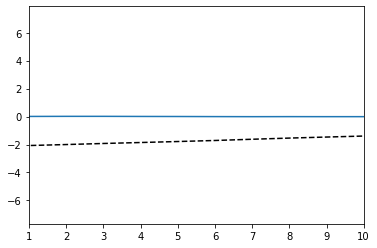

In [95]:
plt.figure
plt.plot(acc_IL[1,:],'k--')
plt.plot(acc_IL1[1,:])
plt.xlim([1,10])
plt.show()

In [96]:
# Finding indices for strain locations whihc will be fused 
sensor_diff_il = np.abs(np.tile(str_il,(8,1)).T - acc_pos)
sensor_transform_index_il = np.argmin(sensor_diff_il,axis=1)

sensor_diff_cf = np.abs(np.tile(str_cf,(8,1)).T - acc_pos)
sensor_transform_index_cf = np.argmin(sensor_diff_cf,axis=1)

In [103]:
#X = np.vstack((time,pos_IL,pos_CF,vel_IL,vel_CF,acc_IL,acc_CF)).transpose()
X = np.vstack((time,acc_IL,acc_CF)).transpose()
#Y = np.vstack((strain_CF.argmax(axis=0),strain_IL.argmax(axis=0))).transpose()
Y = np.vstack((strain_CF.argmax(axis=0))).transpose()
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
#Y = (Y-Y.min())/(Y.max()-Y.min())

n_features = X.shape[1]
b_size = 100
n_outputs = Y.shape[0]

n_batches = int(X.shape[0]/b_size)
X = X.reshape(n_batches,b_size,n_features)
Y = Y.reshape(n_batches,b_size,n_outputs)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42,shuffle=False)

t_train = X_train[:,:,0]
t_test = X_test[:,:,0]
X_train = X_train[:,:,0:-1]
X_test = X_test[:,:,0:-1]

n_features = n_features-1
n_outputs = Y.max()+1

In [104]:
model = Sequential(name="Vanilla")
model.add(Dense(5, activation="relu", name="layer1"))
model.add(Dense(10, activation="relu", name="layer2"))
model.add(Dense(50, activation="relu", name="layer3"))
model.add(Dense(50, activation="relu", name="layer4"))
model.add(Dense(20, activation="relu", name="layer5"))
model.add(Dense(n_outputs, name="output_layer",activation='softmax'))
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=['SparseCategoricalAccuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(X_train,y_train,epochs=100,callbacks=callback)

Epoch 1/100
8/8 [==============================] - 1s 13ms/step - loss: 3.1744 - sparse_categorical_accuracy: 0.0536
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 3.1592 - sparse_categorical_accuracy: 0.0809
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 3.1439 - sparse_categorical_accuracy: 0.0922
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 3.1231 - sparse_categorical_accuracy: 0.0941
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 3.0964 - sparse_categorical_accuracy: 0.1047
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 3.0647 - sparse_categorical_accuracy: 0.1057
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 3.0312 - sparse_categorical_accuracy: 0.1043
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 2.9974 - sparse_categorical_accuracy: 0.1051
Epoch 9/100
8/8 [==============================] - 0s 12ms/step 

8/8 [==============================] - 0s 20ms/step - loss: 2.0854 - sparse_categorical_accuracy: 0.3226
Epoch 71/100
8/8 [==============================] - 0s 22ms/step - loss: 2.0820 - sparse_categorical_accuracy: 0.3223
Epoch 72/100
8/8 [==============================] - 0s 21ms/step - loss: 2.0808 - sparse_categorical_accuracy: 0.3233
Epoch 73/100
8/8 [==============================] - 0s 20ms/step - loss: 2.0772 - sparse_categorical_accuracy: 0.3226
Epoch 74/100
8/8 [==============================] - 0s 20ms/step - loss: 2.0758 - sparse_categorical_accuracy: 0.3235
Epoch 75/100
8/8 [==============================] - 0s 20ms/step - loss: 2.0727 - sparse_categorical_accuracy: 0.3230
Epoch 76/100
8/8 [==============================] - 0s 21ms/step - loss: 2.0715 - sparse_categorical_accuracy: 0.3247
Epoch 77/100
8/8 [==============================] - 0s 19ms/step - loss: 2.0657 - sparse_categorical_accuracy: 0.3272
Epoch 78/100
8/8 [==============================] - 0s 19ms/step - lo

In [111]:
y_pred_NN = model.predict(X_test)
y_pred_NN = y_pred.argmax(axis=2)

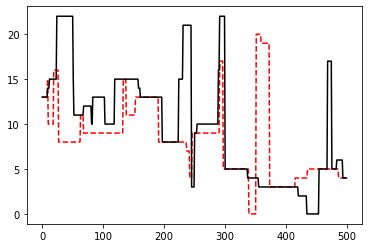

In [112]:
n = 20
plt.figure(figsize=(15,10))
plt.plot(y_pred_NN[n,:],'r--')
plt.plot(y_test[n,:],'k-')

In [141]:
model = Sequential(name='LSTM')
model.add(LSTM(
    units=100,
    batch_input_shape=(None,X.shape[1],n_features),
    return_sequences=True),
    dropout=0,
    recurrent_dropout=0)
model.add(LSTM(
    units=500,
    batch_input_shape=(None,X.shape[1],n_features),
    return_sequences=True),
    dropout=0.1,
    recurrent_dropout=0)
model.add(Dense(50,activation='relu'))
model.add(Dropout(0))
model.add(Dense(n_outputs, activation='softmax'))

model.summary()
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=['SparseCategoricalAccuracy'])

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 500, 100)          46800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 500, 500)          1202000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 500, 500)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 500, 50)           25050     
_________________________________________________________________
dropout_5 (Dropout)          (None, 500, 50)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 500, 24)           1224   

In [142]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(X_train,y_train,epochs=100,callbacks=callback)

Epoch 1/100
8/8 [==============================] - 29s 3s/step - loss: 2.9173 - sparse_categorical_accuracy: 0.1772
Epoch 2/100
8/8 [==============================] - 30s 4s/step - loss: 2.4178 - sparse_categorical_accuracy: 0.2760
Epoch 3/100
8/8 [==============================] - 31s 4s/step - loss: 2.1786 - sparse_categorical_accuracy: 0.3359
Epoch 4/100
8/8 [==============================] - 30s 4s/step - loss: 2.0178 - sparse_categorical_accuracy: 0.3824
Epoch 5/100
8/8 [==============================] - 33s 4s/step - loss: 1.8911 - sparse_categorical_accuracy: 0.4139
Epoch 6/100
8/8 [==============================] - 31s 4s/step - loss: 1.8202 - sparse_categorical_accuracy: 0.4272
Epoch 7/100
8/8 [==============================] - 34s 4s/step - loss: 1.7198 - sparse_categorical_accuracy: 0.4547
Epoch 8/100
8/8 [==============================] - 32s 4s/step - loss: 1.6275 - sparse_categorical_accuracy: 0.4828
Epoch 9/100
8/8 [==============================] - 30s 4s/step - loss: 1

8/8 [==============================] - 182s 23s/step - loss: 0.1467 - sparse_categorical_accuracy: 0.9480
Epoch 71/100
8/8 [==============================] - 187s 23s/step - loss: 0.1440 - sparse_categorical_accuracy: 0.9490
Epoch 72/100
8/8 [==============================] - 183s 23s/step - loss: 0.1446 - sparse_categorical_accuracy: 0.9483
Epoch 73/100
8/8 [==============================] - 195s 24s/step - loss: 0.1452 - sparse_categorical_accuracy: 0.9475
Epoch 74/100
8/8 [==============================] - 186s 23s/step - loss: 0.1476 - sparse_categorical_accuracy: 0.9466


In [148]:
model.save('RNN')

INFO:tensorflow:Assets written to: RNN\assets


INFO:tensorflow:Assets written to: RNN\assets


KeyboardInterrupt: 

In [143]:
y_pred = model.predict(X_test)
y_pred=y_pred.argmax(axis=2)

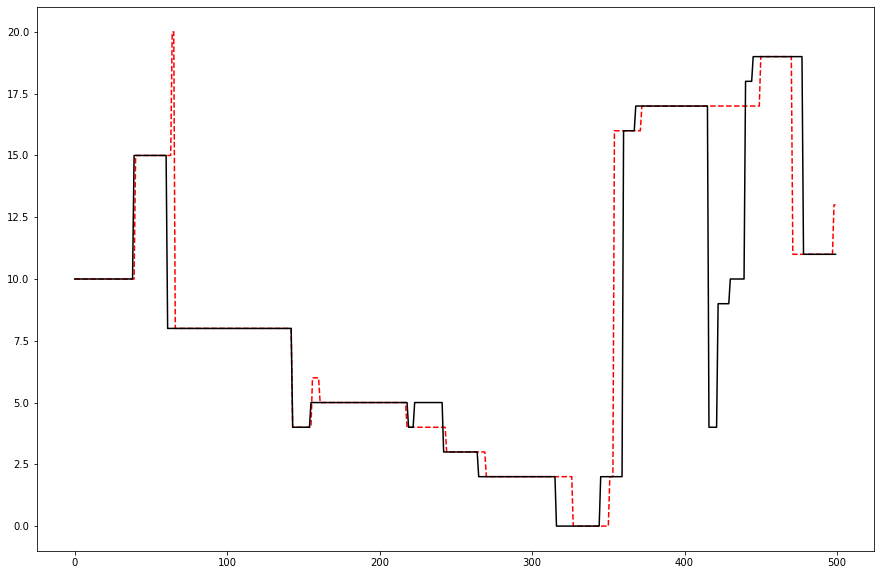

In [144]:
n = 0
plt.figure(figsize=(15,10))
plt.plot(y_pred[n,:],'r--')
plt.plot(y_test[n,:],'k-')
plt.show()

0.523781512605042


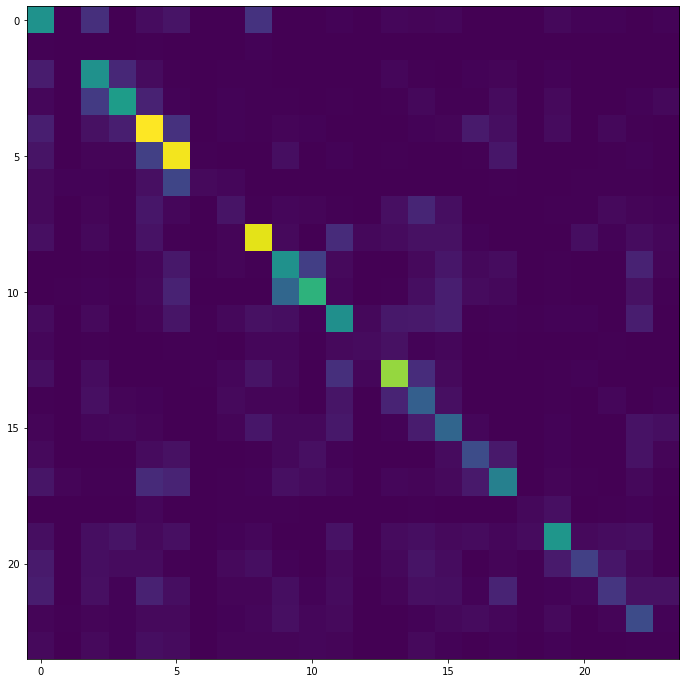

In [146]:
from sklearn.metrics import confusion_matrix

y_p = y_pred.reshape(-1,1)
y_true = y_test.reshape(-1,1)

cm = confusion_matrix(y_true,y_p)
misclassification_rate = 1-np.diagonal(cm).sum()/y_true.shape[0]
print(misclassification_rate)

from seaborn import heatmap

plt.figure(figsize=(12,12))
plt.imshow(cm)
plt.show()

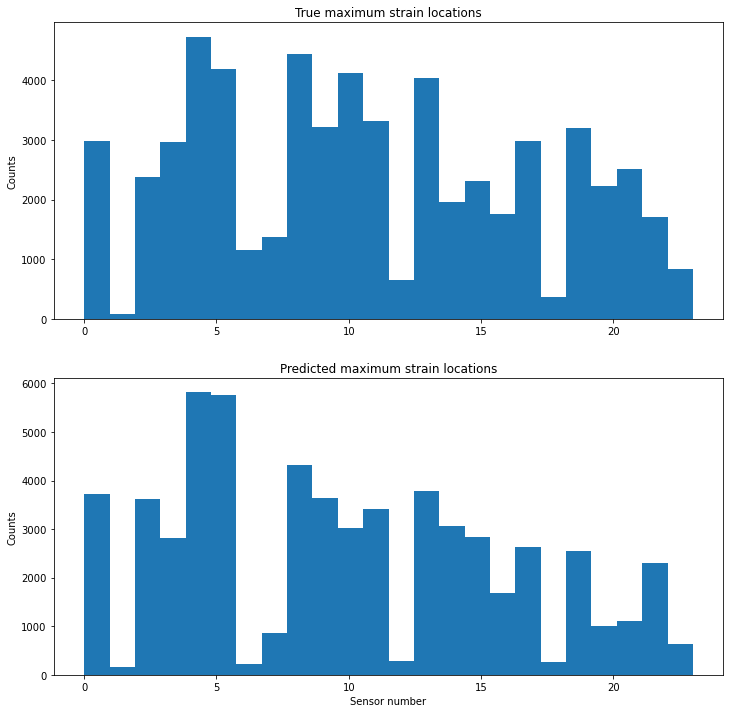

In [147]:
fig, ax = plt.subplots(2,figsize=(12,12))
ax[0].hist(y_true,bins=24)
ax[1].hist(y_p,bins=24)
ax[1].set_xlabel('Sensor number')
ax[0].set_ylabel('Counts')
ax[1].set_ylabel('Counts')
ax[0].set_title('True maximum strain locations')
ax[1].set_title('Predicted maximum strain locations')
plt.show()

## CNN 2D

In [ ]:
X = np.vstack((pos_IL,pos_CF)).transpose()
Y = np.vstack((strain_CF.argmax(axis=0)))

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42,shuffle=False)

n_features = X_train.shape[1]
n_outputs = Y.max()+1

X_train = X_train.reshape(X_train.shape[0],int(n_features/2),2,1)
X_test = X_test.reshape(X_test.shape[0],int(n_features/2),2,1)

In [ ]:
input_shape=(None,8,2,1)
model = Sequential(name='CNN')
model.add(Input(shape=(8,2,1)))
model.add(Conv2D(
            filters=32,
            kernel_size=(2,2),
            strides=1,
            activation='tanh',
            padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(n_outputs, activation='softmax'))
model.summary()
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=['SparseCategoricalAccuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(X_train,y_train,epochs=100,callbacks=callback,batch_size=b_size)

In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)

In [ ]:
f1 = 1
f2 = 1

plt.figure(figsize=(12,12))
plt.plot(X_test[:,f1,f2,:],y_test,'bo')
plt.plot(X_test[:,f1,f2,:],y_pred,'r.')
plt.title('CF')

#plt.figure(figsize=(12,12))
#plt.plot(X_test[n,:,f],y_test[n,:,1],'b-')
#plt.plot(X_test[n,:,f],y_pred[n,:,1],'r-')
#plt.title('CF')



In [ ]:
from sklearn.metrics import confusion_matrix

y_p = y_pred.reshape(-1,1)
y_true = y_test.reshape(-1,1)

cm = confusion_matrix(y_true,y_p)

In [ ]:
misclassification_rate = 1-np.diagonal(cm).sum()/y_true.shape[0]
print(misclassification_rate)

In [ ]:
from seaborn import heatmap

plt.figure(figsize=(12,12))
plt.imshow(cm)
plt.show()